# Modeling Dopamine using RL framework

The main objective of this notebook is to replicate two crucial papers that returns important results of the understanding of the Dopamine in the Brain:

- *[1] Schultz, W., Dayan, P., & Montague, P. R. (1997). A neural substrate of prediction and reward. Science, 275(5306), 1593-1599.*

- *[2] Dabney, W., Kurth-Nelson, Z., Uchida, N., Starkweather, C. K., Hassabis, D., Munos, R., & Botvinick, M. (2020). A distributional code for value in dopamine-based reinforcement learning. Nature, 577(7792), 671-675.*

and if possible go further in ideas on how free-model RL and base-model RL can help us to understand Brain parts.

### Generalities
In essence Wolfram Schultz was studying experimentally the relation between dopamine neurons and rewards.

* Ljungberg, T., Apicella, P., & Schultz, W. (1992). Responses of monkey dopamine neurons during learning of behavioral reactions. Journal of neurophysiology, 67(1), 145-163.

At same time, Peter Dayan found a framework that works for modeling dopamine responses: 
* Montague, P. R., Dayan, P., Person, C., & Sejnowski, T. J. (1995). Bee foraging in uncertain environments using predictive hebbian learning. Nature, 377(6551), 725-728.

Then, paper [1], is fundamental in the relantionship between **reward prediction error** and **dopamine activity**.

Details about the implementation are given in: https://compneuro.neuromatch.io/tutorials/W3D4_ReinforcementLearning/student/W3D4_Tutorial1.html 


### Part 1: Reinforcement Learning Framework.
# 
# ![Agent-Environment interaction](agent_env_plot.png)

- The agent experiences the environment in episodes.
- The agent does not perform actions in this setup.
- The classical conditioning environment is composed of a sequence of states that the agent deterministically transitions through. $S_0$ -> $S_1$ -> $S_2$, each one in a step.
 These states represent time in what is called “tapped delay line” representation, which basically an episode that captures all the series of states. Terminal state used to predict the reward.
 - Inside each episode, the agent is presented with a CS (Conditioned Stimuli) and US (reward), where CS is presented at the beggining and US, shortly after some time.
 -  The agent’s goal is to learn to predict expected rewards from each state in the trial.










 ### Part 2: Crucial Equations

##### Return $G_t$ 
 $G_t = \sum_{k=0}^{\infty} \gamma^k r_{t+k+1}$

where $r_t$ is the reward received at time t, and $\gamma$ the discount factor.

##### Value Function $V_\pi(s)$ 
Denoting $s_t$, as the state at time t and $\pi(a|s)$ as the probability of an action at state s, we can quantify the expected return, starting with state $s$ and following policy $\pi$ as, 

 $V_\pi(s) = \mathbb{E}[G_t|s_t=s]$
 
 $V_\pi(s) = \mathbb{E}[r_{t+1} + \gamma G_{t+1}|s_t=s]$
 
 $V_\pi(s) = \mathbb{E}[r_{t+1} + \gamma V_\pi(s_{t+1})|s_t=s]$

  $V_\pi(s) = \sum_a \pi(a|s) \sum_{s',r} p(s',r|s) [r + \gamma V_\pi(s')]$

##### Temporal Difference Learning (TD)

 Both TD and Monte Carlo methods use experience to solve the prediction problem. The difference is that TD methods need to wait only until the next time step in order to update, so:

 $\delta_t = R_{t+1} + \gamma V(s_{t+1}) - V(s_t)$ 

In essence, first $\delta_t$ measures TD-error measures the discrepancy between values at time t and t+1, then we update

  $V(s_t) \leftarrow V(s_t) + \alpha \delta_t$






## Part 3: Results

### Case 1: TD-learning with guaranteed rewards

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [64]:
# Reward guesser, how good is reward predicted with real reward	
def reward_guesser_title_hint(r1, r2):
  """"Provide a mildly obfuscated hint for a demo."""
  if (r1==14 and r2==6) or (r1==6 and r2==14):
    return "Technically correct...(the best kind of correct)"

  if  ~(~(r1+r2) ^ 11) - 1 == (6 | 24): # Don't spoil the fun :-)
    return "Congratulations! You solved it!"

  return "Keep trying...."


# Classical Conditions, like Pavlovian conditioning.
class ClassicalConditioning:

    def __init__(self, n_steps, reward_magnitude, reward_time):

        # Task variables
        self.n_steps = n_steps
        self.n_actions = 0
        self.cs_time = int(n_steps/4) - 1

        # Reward variables
        self.reward_state = [0,0]
        self.reward_magnitude = None
        self.reward_probability = None
        self.reward_time = None

        # Time step at which the conditioned stimulus is presented
        self.set_reward(reward_magnitude, reward_time)

        # Create a state dictionary
        self._create_state_dictionary()

    def set_reward(self, reward_magnitude, reward_time):

        """
        Determine reward state and magnitude of reward
        """
        # Too late reward == no reward.
        if reward_time >= self.n_steps - self.cs_time:
            self.reward_magnitude = 0

        else:
            self.reward_magnitude = reward_magnitude
            self.reward_state = [1, reward_time]

    def get_outcome(self, current_state):

        """
        Determine next state and reward
        """
        # Update state
        if current_state < self.n_steps - 1:
            next_state = current_state + 1
        else:
            next_state = 0

        # Check for reward
        if self.reward_state == self.state_dict[current_state]:
            reward = self.reward_magnitude
        else:
            reward = 0
        return next_state, reward

    # Safe info of each step: 
    # if you are on cs or not, 
    # and how much time (delay) you wait until the reward.
    def _create_state_dictionary(self):

        """
        This dictionary maps number of time steps/ state identities
        in each episode to some useful state attributes:

        state      - 0 1 2 3 4 5 (cs) 6 7 8 9 10 11 12 ...
        is_delay   - 0 0 0 0 0 0 (cs) 1 1 1 1  1  1  1 ...
        t_in_delay - 0 0 0 0 0 0 (cs) 1 2 3 4  5  6  7 ...
        """
        d = 0

        self.state_dict = {}
        for s in range(self.n_steps):
            if s <= self.cs_time:
                self.state_dict[s] = [0,0]
            else:
                d += 1 # Time in delay
                self.state_dict[s] = [1,d]

# Class inside class: 
# Multi-reward is same as ClassicalConditioning, but now reward magnitude is random.
# Always reward, but random.
class MultiRewardCC(ClassicalConditioning):
  """Classical conditioning paradigm, except that one randomly selected reward,
    magnitude, from a list, is delivered of a single fixed reward."""
  def __init__(self, n_steps, reward_magnitudes, reward_time=None):
    """"Build a multi-reward classical conditioning environment
      Args:
        - nsteps: Maximum number of steps
        - reward_magnitudes: LIST of possible reward magnitudes.
        - reward_time: Single fixed reward time
      Uses numpy global random state.
      """
    super().__init__(n_steps, 1, reward_time)
    self.reward_magnitudes = reward_magnitudes

  def get_outcome(self, current_state):
    next_state, reward = super().get_outcome(current_state)
    if reward:
      reward=np.random.choice(self.reward_magnitudes)
    return next_state, reward

# ProbabilisticCC is same as ClassicalConditioning:
# but now reward is probabilistic,
# if p_reward is 1, then it is the same as ClassicalConditioning.
# if p_reward is 0, then there is no reward.
class ProbabilisticCC(ClassicalConditioning):
  """Classical conditioning paradigm, except that rewards are stochastically omitted."""
  def __init__(self, n_steps, reward_magnitude, reward_time=None, p_reward=0.75):
    """"Build a multi-reward classical conditioning environment
      Args:
        - nsteps: Maximum number of steps
        - reward_magnitudes: Reward magnitudes.
        - reward_time: Single fixed reward time.
        - p_reward: probability that reward is actually delivered in rewarding state
      Uses numpy global random state.
      """
    super().__init__(n_steps, reward_magnitude, reward_time)
    self.p_reward = p_reward

  def get_outcome(self, current_state):
    next_state, reward = super().get_outcome(current_state)
    if reward:
      reward*= int(np.random.uniform(size=1)[0] < self.p_reward)
    return next_state, reward

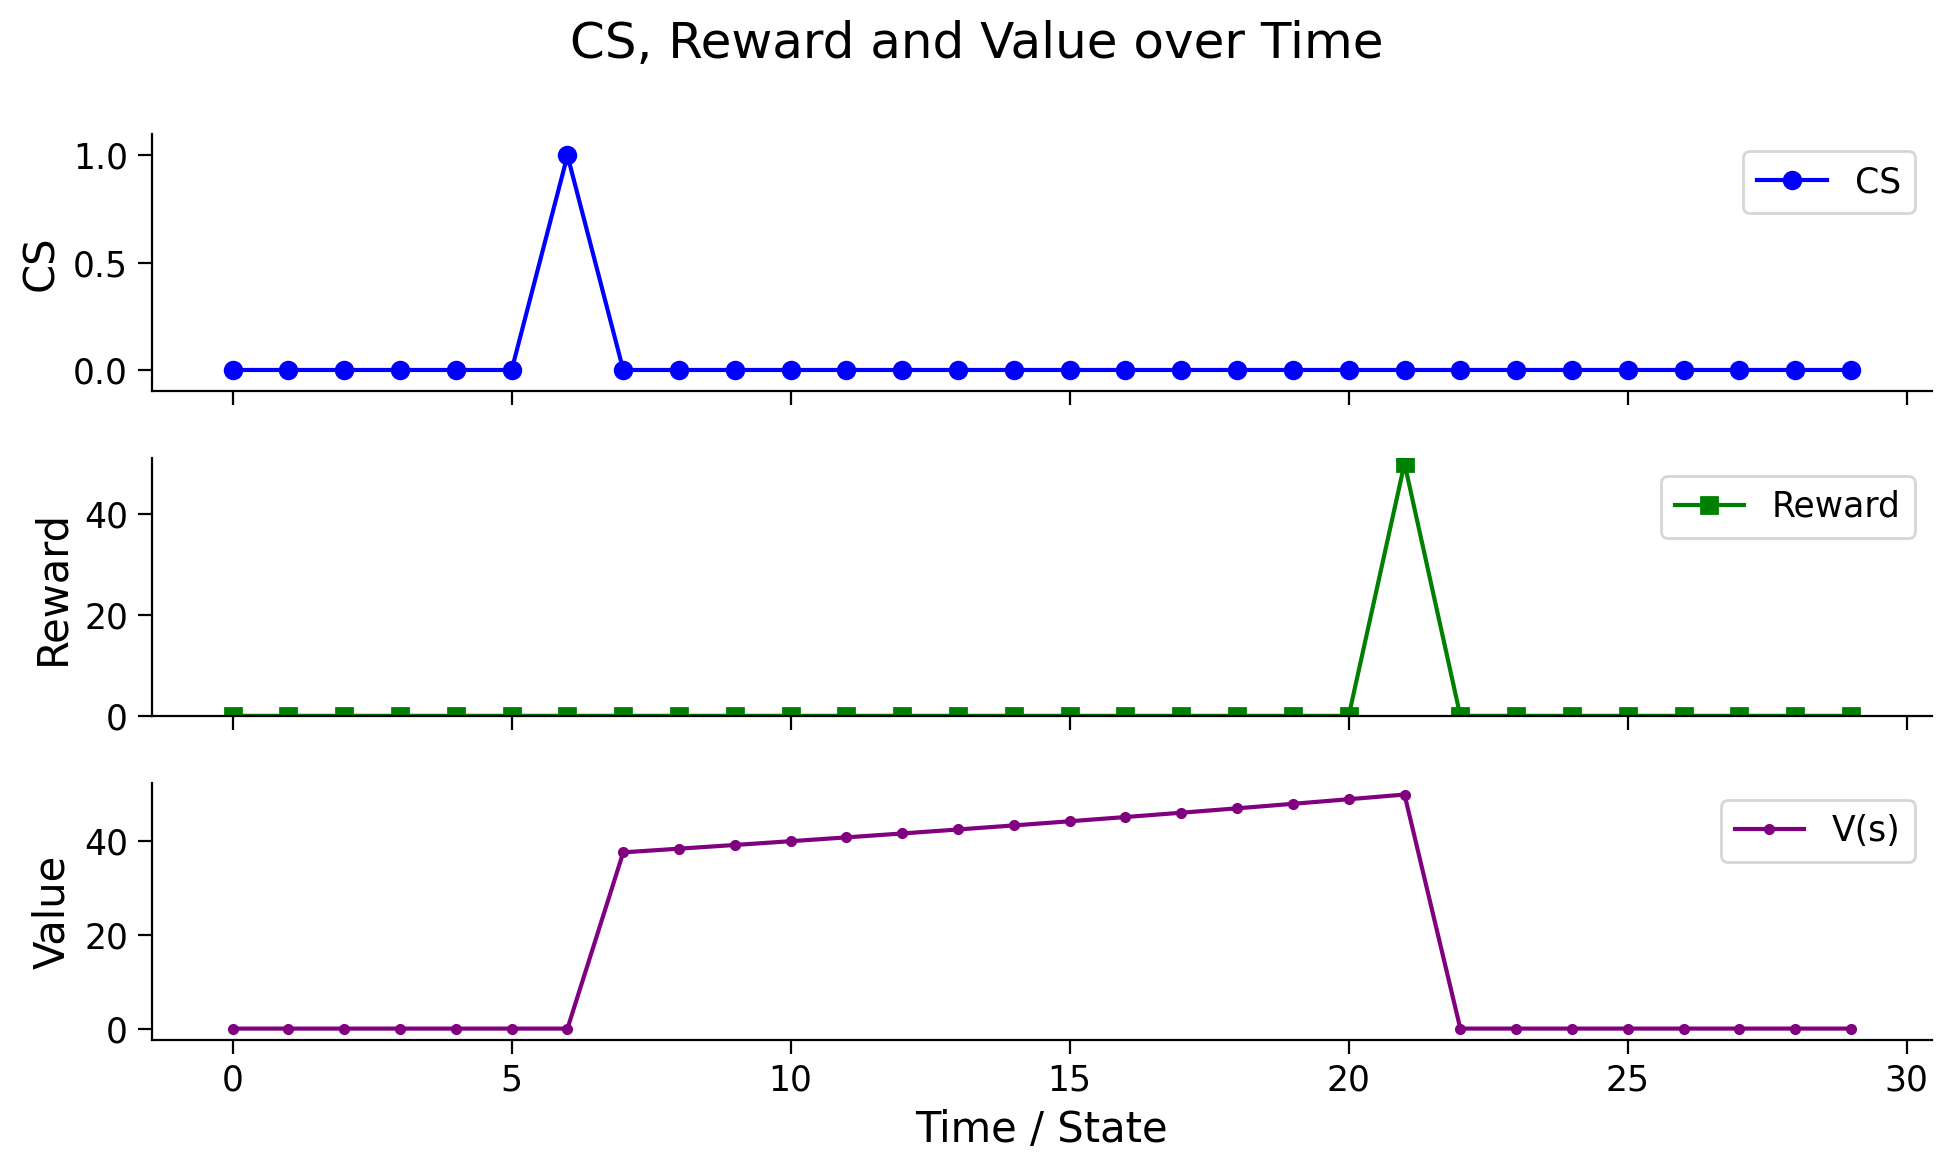

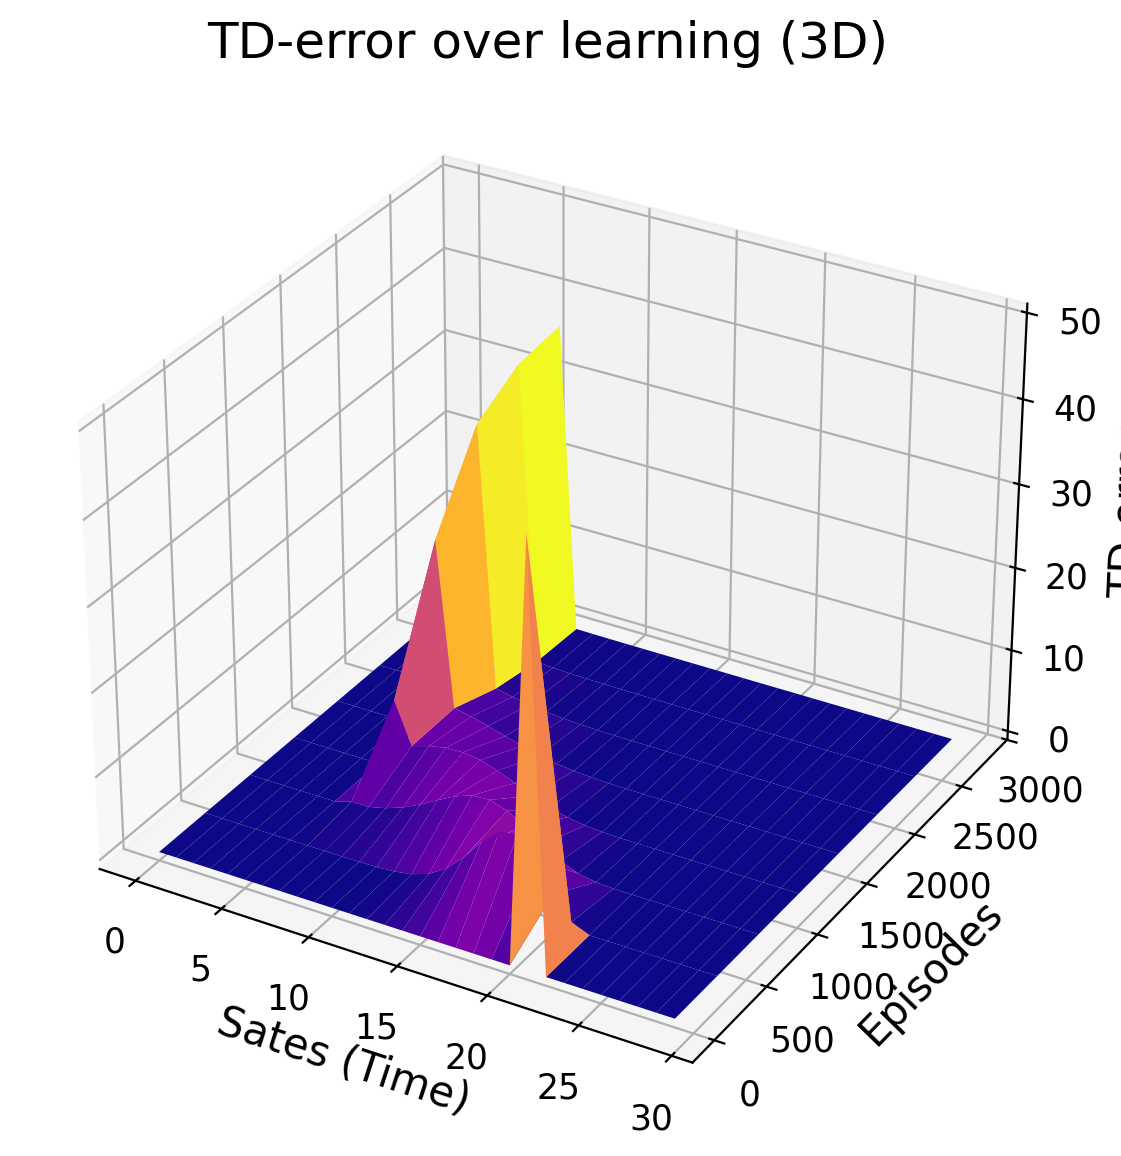

In [65]:
def td_learner(env, n_trials, gamma=0.98, alpha=0.01):
  """ Temporal Difference learning

  Args:
    env (object): the environment to be learned
    n_trials (int): the number of trials to run
    gamma (float): temporal discount factor
    alpha (float): learning rate

  Returns:
    ndarray, ndarray: the value function and temporal difference error arrays
  """
  V = np.zeros(env.n_steps) # Array to store values over states (time)
  TDE = np.zeros((env.n_steps, n_trials)) # Array to store TD errors

  for n in range(n_trials):

    state = 0 # Initial state

    for t in range(env.n_steps):

      # Get next state and next reward
      next_state, reward = env.get_outcome(state)

      # Is the current state in the delay period (after CS)?
      is_delay = env.state_dict[state][0]

      # TD-error
      td_error = reward + gamma * V[next_state] - V[state]
      TDE[state, n] = td_error
      # Update value function
      V[state] += alpha * td_error * is_delay
      # Update state
      state = next_state

  return V, TDE

def plot_event_sequence_over_episode(env, V):
  """
  Plots a single episode showing:
    - CS presence
    - Reward occurrence
    - Value function V(s)
  """

  states = np.arange(env.n_steps)
  cs_flags = np.zeros(env.n_steps)
  rewards = np.zeros(env.n_steps)

  # marcar dónde aparece el CS
  cs_flags[env.cs_time] = 1

  # buscar el estado donde se entrega el reward
  for state in range(env.n_steps):
    is_delay, t_in_delay = env.state_dict[state]
    if [is_delay, t_in_delay] == env.reward_state:
      rewards[state] = env.reward_magnitude

  fig, ax = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

  ax[0].plot(states, cs_flags, label="CS", color='blue', marker='o')
  ax[0].set_ylabel("CS")
  ax[0].set_ylim([-0.1, 1.1])
  ax[0].legend()

  ax[1].plot(states, rewards, label="Reward", color='green', marker='s')
  ax[1].set_ylabel("Reward")
  ax[1].set_ylim([0, env.reward_magnitude + 1])
  ax[1].legend()

  ax[2].plot(states, V, label="V(s)", color='purple', marker='.')
  ax[2].set_ylabel("Value")
  ax[2].set_xlabel("Time / State")
  ax[2].legend()

  plt.suptitle("CS, Reward and Value over Time")
  plt.tight_layout()
  plt.show()


def plot_tde_3d(TDE, skip=400):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Subsample to make the plot faster
    trials = np.arange(0, TDE.shape[1], skip)
    states = np.arange(TDE.shape[0])

    X, Y = np.meshgrid(trials, states)
    Z = TDE[:, trials]

    ax.plot_surface(Y, X, Z, cmap=cm.plasma)
    ax.set_xlabel('Sates (Time)')
    ax.set_ylabel('Episodes')
    ax.set_zlabel('TD-error')
    ax.set_title('TD-error over learning (3D)')
    # Cambiá estos valores para rotar el ángulo de vista
    # ax.view_init(elev=5, azim=0)

    plt.tight_layout()
    plt.show()

# Initialize classical conditioning class
# CS will happen at n_steps/4, approx
# US will happen at n_steps/2, approx
env = ClassicalConditioning(n_steps=30, reward_magnitude=50, reward_time=15)
# Perform temporal difference learning
V, TDE = td_learner(env, n_trials=3000)
plot_event_sequence_over_episode(env, V)
plot_tde_3d(TDE)


1) After many episodes, CS starts to predict the future reward, so when the reward arrives you were already expecting the reward and there is no prediction error. 
2) At beggining of learning the Reward Prediction Error appears when appears the reward, but at the end of learning, the Reward Prediction Error picks at the beggining.

### US to CS Transfer of TD-error
Same as Pavlov ringing the bell generates the salivating related to the reward. Conditional Stimuli predicts the Unconditional Stimuli (e.g. salivating). 
The delay period has zero reward, so in this time the TD-error result from inconsistencies between $V(s')$ and $V(s)$. Then, there is a kind of backward move of the TD-error from US to CS. 

In [66]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [67]:
n_trials = 3000

@widgets.interact
def plot_tde_by_trial(trial = widgets.IntSlider(value=50000, min=0, max=n_trials-1 , step=1, description="Trial #")):
  if 'TDE' not in globals():
    print("Complete Exercise 1 to enable this interactive demo!")
  else:

    fig, ax = plt.subplots()
    ax.axhline(0, color='k') # Use this + basefmt=' ' to keep the legend clean.
    ax.stem(TDE[:, 0], linefmt='C1-', markerfmt='C1d', basefmt=' ',
            label="Before Learning (Trial 0)")
    ax.stem(TDE[:, -1], linefmt='C2-', markerfmt='C2s', basefmt=' ',
            label=r"After Learning (Trial $\infty$)")
    ax.stem(TDE[:, trial], linefmt='C0-', markerfmt='C0o', basefmt=' ',
            label=f"Trial {trial}")

    ax.set_xlabel("State in trial")
    ax.set_ylabel("TD Error")
    ax.set_title("Temporal Difference Error by Trial")
    ax.legend()
    plt.show()

interactive(children=(IntSlider(value=2999, description='Trial #', max=2999), Output()), _dom_classes=('widget…

We can see clearly, that given a certain number of episodes, we transfer a certain TD-Error.

### Role of $\alpha$,  $\gamma$ in the backward process.

On TD-learning, 
- $\alpha$ controls learning rate — how much to trust each new $\delta_t$.
- $\gamma$ discounts future rewards — higher $\gamma$ values mean more future-oriented learning.


 $\delta_t = R_{t+1} + \gamma V(s_{t+1}) - V(s_t)$ 
 
 $V(s_t) \leftarrow V(s_t) + \alpha \delta_t$

In [68]:
from matplotlib import ticker

def plot_value_function(V, ax=None, show=True):
    """Plot V(s), the value function"""
    if ax is None:
        fig, ax = plt.subplots()
    ax.stem(V)
    ax.set_ylabel('Value')
    ax.set_xlabel('State')
    ax.set_title("Value function: $V(s)$")
    if show:
        plt.show()

def plot_tde_trace(TDE, ax=None, show=True, skip=400):
    """Plot the TD Error across trials (heatmap 2D)"""
    if ax is None:
        fig, ax = plt.subplots()
    index = np.arange(0, TDE.shape[1], skip)
    im = ax.imshow(TDE[:, index], aspect='auto')
    positions = ax.get_xticks()
    ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
    ax.set_xticklabels([f"{int(skip * x)}" for x in positions])
    ax.set_title('TD-error over learning')
    ax.set_ylabel('State')
    ax.set_xlabel('Iterations')
    ax.figure.colorbar(im, ax=ax)
    if show:
        plt.show()

def plot_tde_3d(TDE, skip=400, elev=30, azim=-60, ax=None, show=True):
    """
    Plot the TD Error across trials in 3D.
    - X axis: episodios (subsampled)
    - Y axis: estados
    - Z axis: magnitud del TD-error
    """
    if ax is None:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')
    # Subsample para acelerar
    trials = np.arange(0, TDE.shape[1], skip)
    states = np.arange(TDE.shape[0])
    X, Y = np.meshgrid(trials, states)
    Z = TDE[:, trials]
    surf = ax.plot_surface(Y, X, Z, cmap=cm.plasma, edgecolor='none')
    ax.set_xlabel('State')          # notación consistente: estados
    ax.set_ylabel('Episode')        # episodios
    ax.set_zlabel('TD-error')
    ax.set_title('TD-error over learning (3D)')
    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    if show:
        plt.tight_layout()
        plt.show()
    return ax

def learning_summary_plot(V, TDE):
    """Summary plot for Ex1 (2D)"""
    fig, (ax1, ax2) = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [1, 2]})
    plot_value_function(V, ax=ax1, show=False)
    plot_tde_trace(TDE, ax=ax2, show=False)
    plt.tight_layout()
    plt.show()

# WIDGET 
@widgets.interact(
    alpha=widgets.FloatSlider(
        value=0.0001, min=0.0001, max=0.1, step=0.0001,
        readout_format='.4f', description="α (alpha)"
    ),
    gamma=widgets.FloatSlider(
        value=0.98, min=0.0, max=1.00, step=0.01,
        readout_format='.3f', description="γ (gamma)"
    ),
    elev=widgets.IntSlider(
        value=30, min=0, max=90, step=5,
        description="Elevación"
    ),
    azim=widgets.IntSlider(
        value=-60, min=-180, max=180, step=10,
        description="Azimut"
    )
)
def plot_summary_alpha_gamma(alpha, gamma, elev, azim):
    """
    Widget que reentrena el agente con (α, γ) dados
    y muestra:
      1) Valor función V(s) (2D)
      2) TD-error heatmap (2D)
      3) TD-error superficie (3D) con ángulos ajustables
    """
    # Inicializar entorno y entrenar
    env = ClassicalConditioning(n_steps=40, reward_magnitude=10, reward_time=10)
    try:
        V_params, TDE_params = td_learner(env, n_trials=20000, gamma=gamma, alpha=alpha)
    except NotImplementedError:
        print("Finish Exercise 1 to enable this interactive demo")
        return

    # 1) y 2) resumen en 2D
    learning_summary_plot(V_params, TDE_params)
    # 3) superficie 3D
    plot_tde_3d(TDE_params, skip=400, elev=elev, azim=azim)


interactive(children=(FloatSlider(value=0.0001, description='α (alpha)', max=0.1, min=0.0001, readout_format='…

We proof that $\alpha$ controls how much you learn and $\gamma$ how far is your oriented learning.

### Case 2: TD-learning with varying reward magnitudes

Now, let's replace the fixed reward magnitude with varying magnitudes (e.g. R₁ = 6, R₂ = 14) to study how TD-learning adapts to reward variability. Clearly, the behavior will preserves as the mean between the magnitude of the rewards preserves.


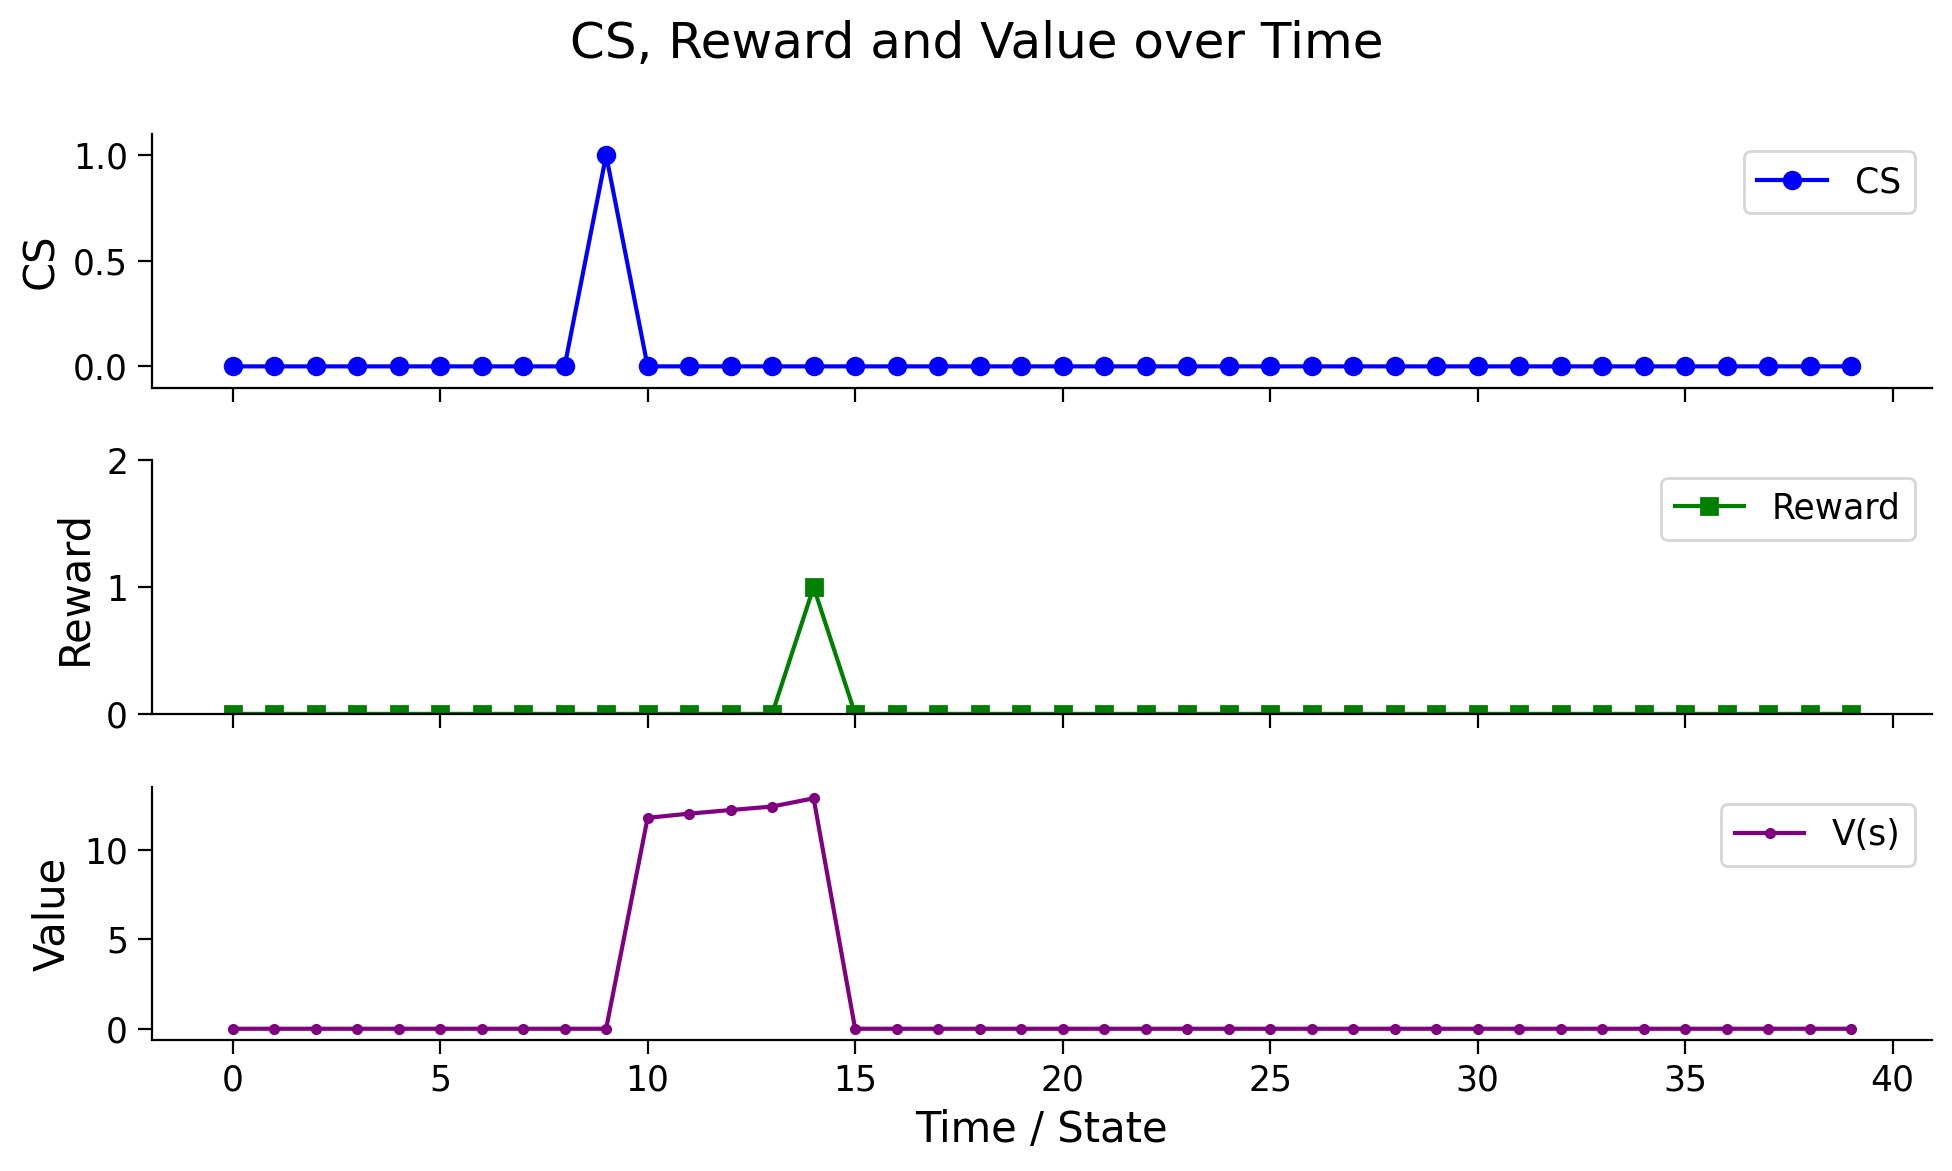

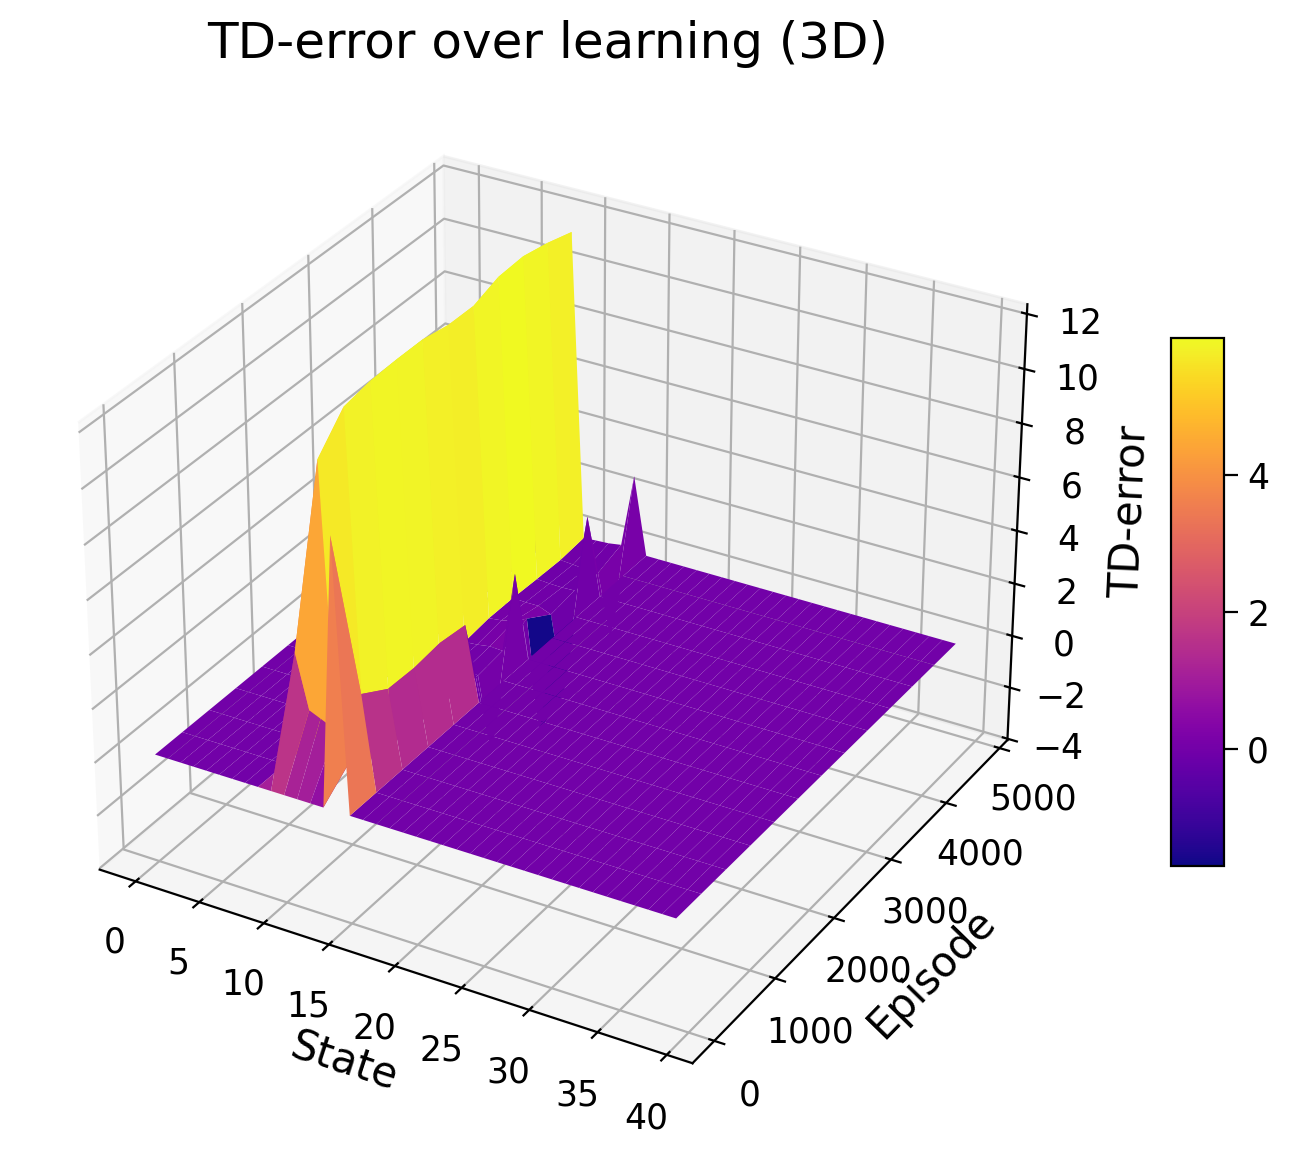

<Axes3D: title={'center': 'TD-error over learning (3D)'}, xlabel='State', ylabel='Episode', zlabel='TD-error'>

In [69]:
env = MultiRewardCC(n_steps=40, reward_magnitudes=[10, 16], reward_time=5)
V, TDE = td_learner(env, n_trials=5000, gamma=0.98, alpha=0.01)
plot_event_sequence_over_episode(env, V)
plot_tde_3d(TDE)

#### New Phenomena:
The TD-prediction now takes on negative values because the reward delivered is sometimes larger than the expected reward and sometimes smaller. Then, if $r_1 = 6$ and $r_2 = 14$,

- 1) TD-negative: $\delta_t =6+\gamma0−14=−8$
- 2) TD on US and CS: As you can see you get a stimate when CS happen, but if the reward is different you got a correction on US, this is why after many episodes the value learned is the mean of the rewards.

### Case 3: TD-learning with probabilistic rewards

In this environment, we will return a reward of fix magnitude, but it will be delivered just 20% of times on US. 

The CS will be on, but sometimes with reward and sometimes not. It is the same as the upper case but now, $r_1=6$ and $r_2=0$. 

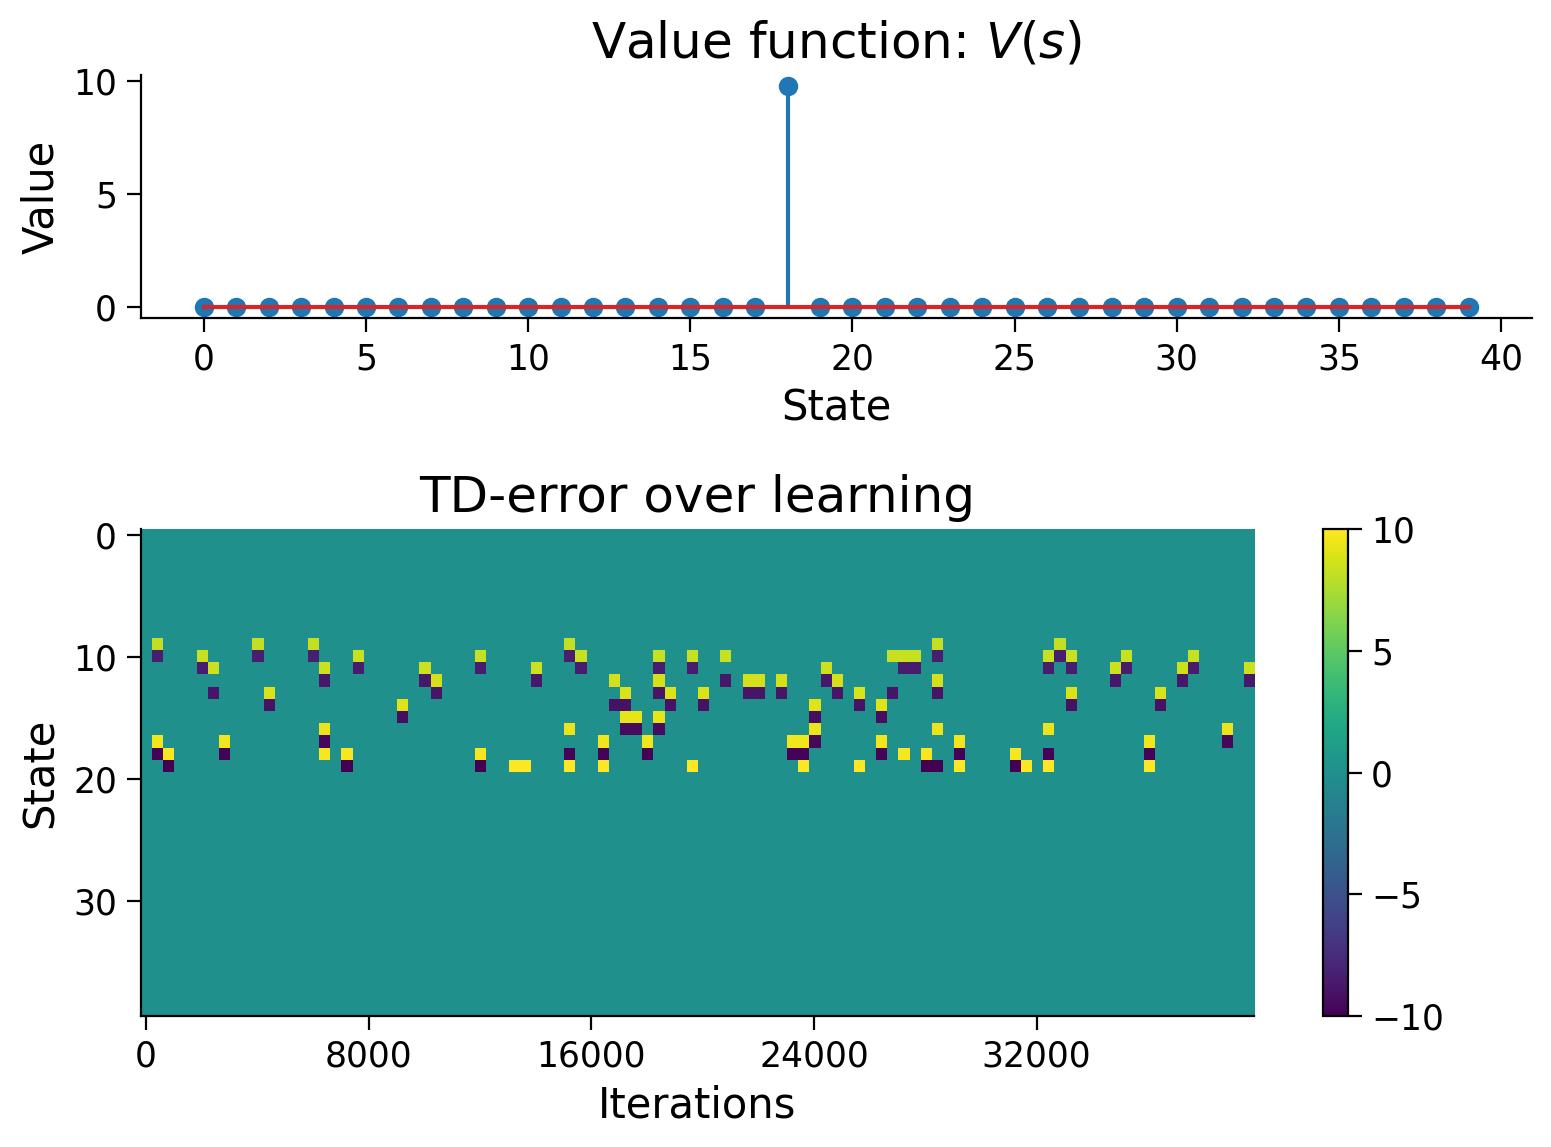

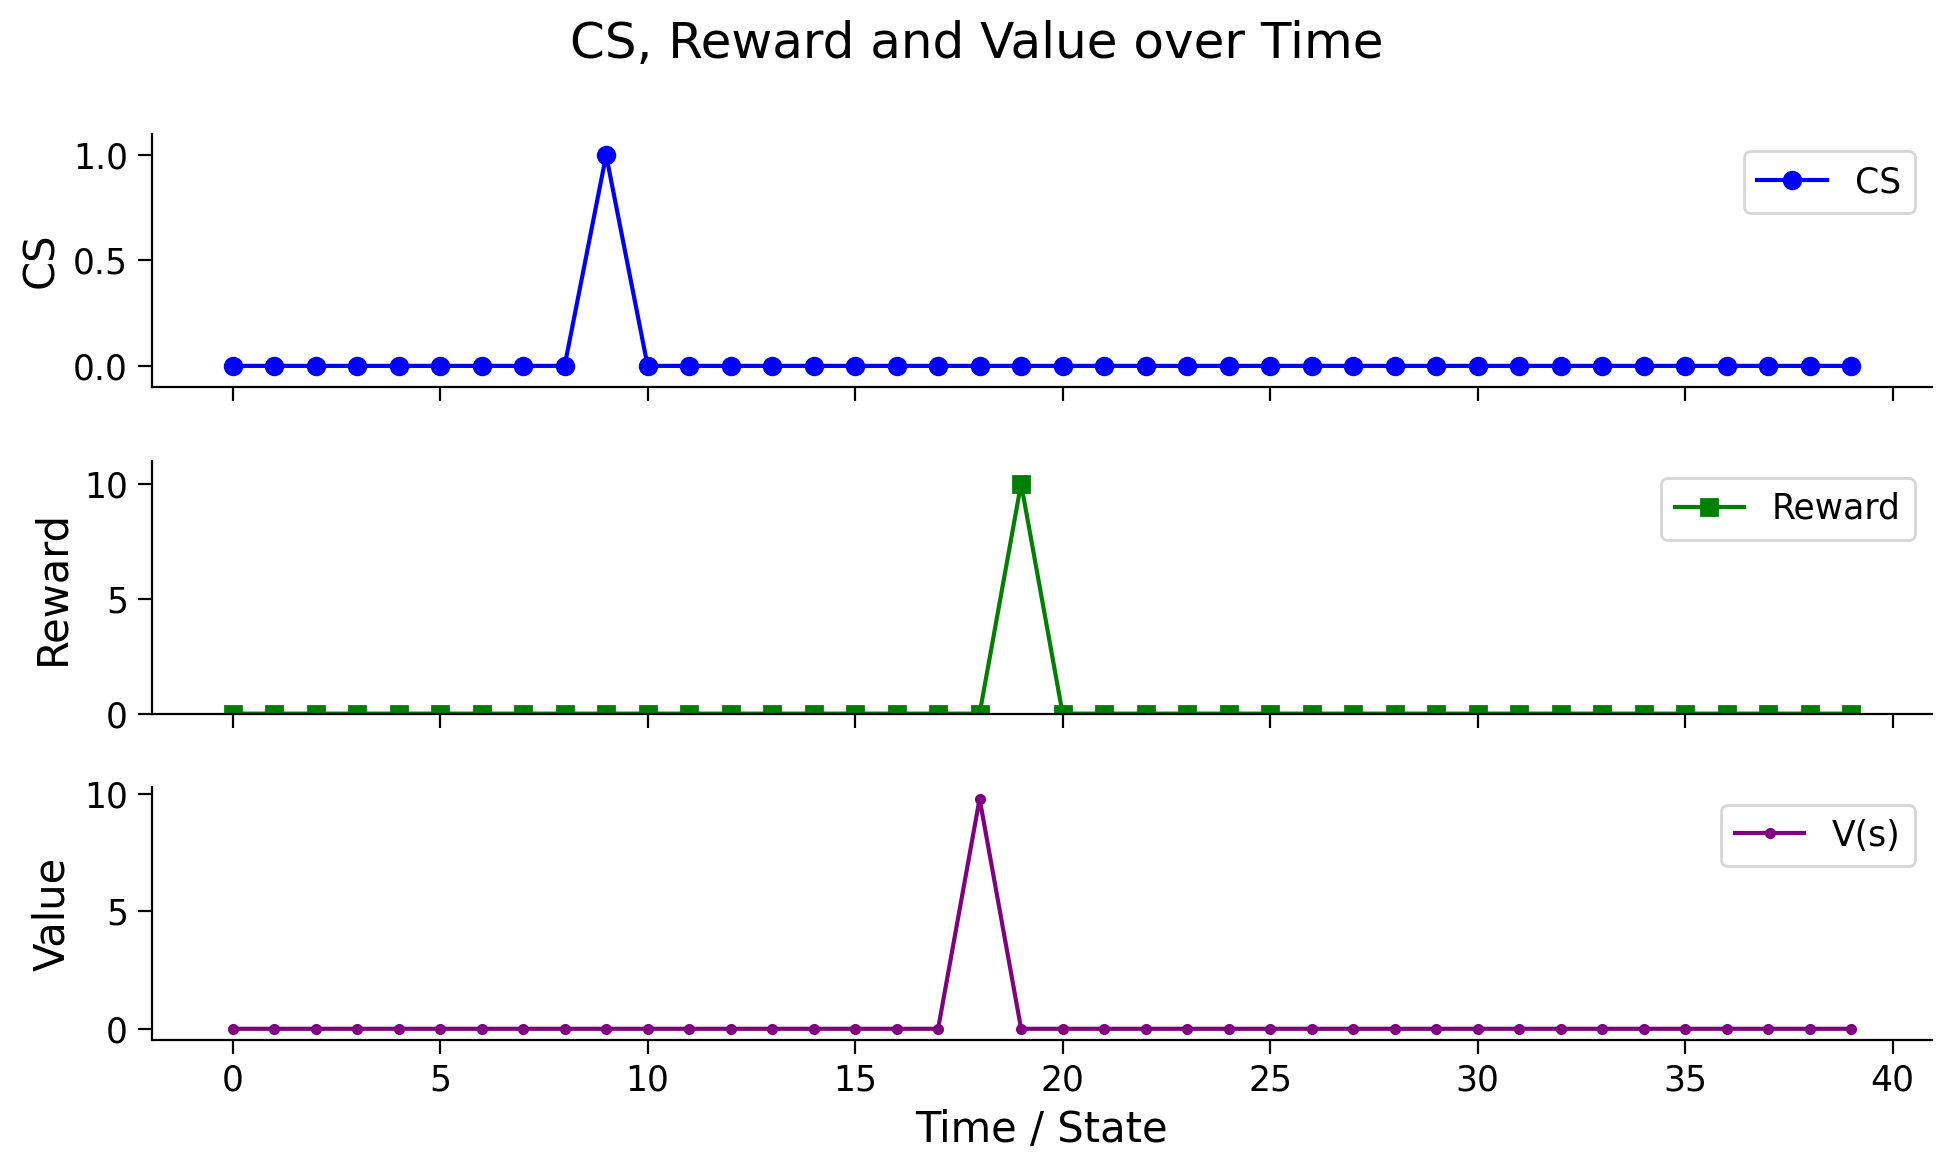

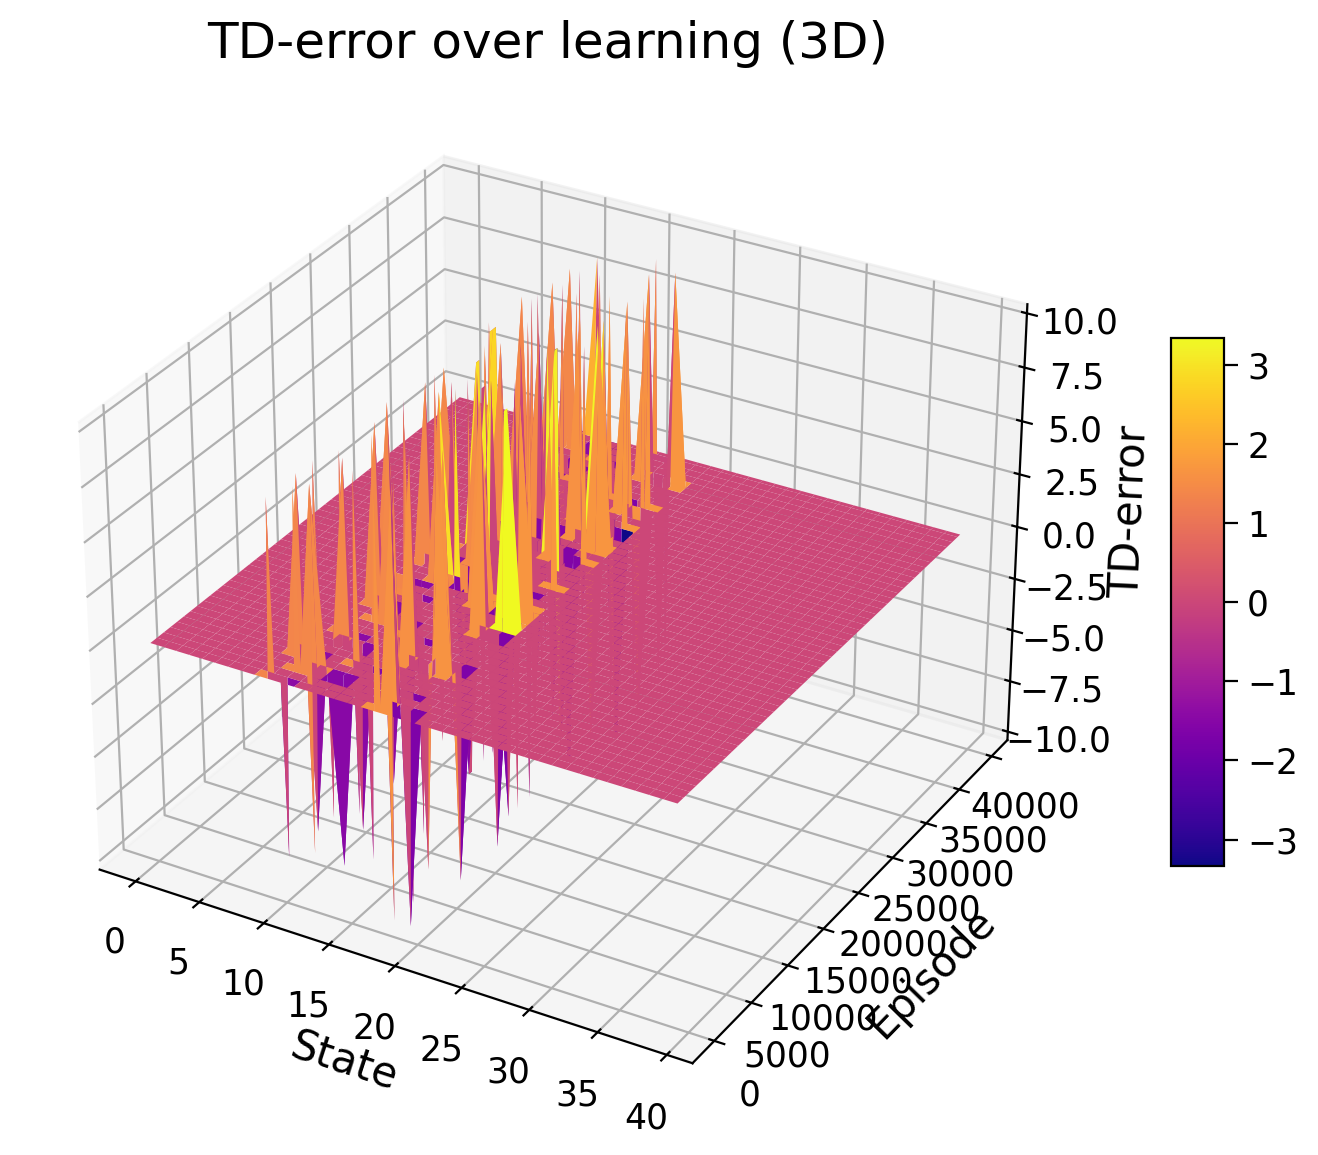

<Axes3D: title={'center': 'TD-error over learning (3D)'}, xlabel='State', ylabel='Episode', zlabel='TD-error'>

In [70]:
# @markdown Execute this cell to visualize the value function and TD-errors when `alpha=1`
rng_state = np.random.get_state()
np.random.set_state(rng_state)  # Resynchronize everyone's notebooks
n_trials = 20000
try:
  env = ProbabilisticCC(n_steps=40, reward_magnitude=10, reward_time=10,
                        p_reward=0.1)
  V_stochastic, TDE_stochastic = td_learner(env, n_trials*2, alpha=1)
  learning_summary_plot(V_stochastic, TDE_stochastic)
except NotImplementedError:
  print("Please finish Exercise 1 first")
plot_event_sequence_over_episode(env, V_stochastic)
plot_tde_3d(TDE_stochastic)

Curiously, ($p$, $\alpha$) are highly relevant for the learning process, maybe, let's consider a macroscopic measures that captures the total variation in learning: 

 $\textbf{Cumulative Volatility} = \sum_{e} \sum_{t} \left| \delta_t^{(e)} \right|$




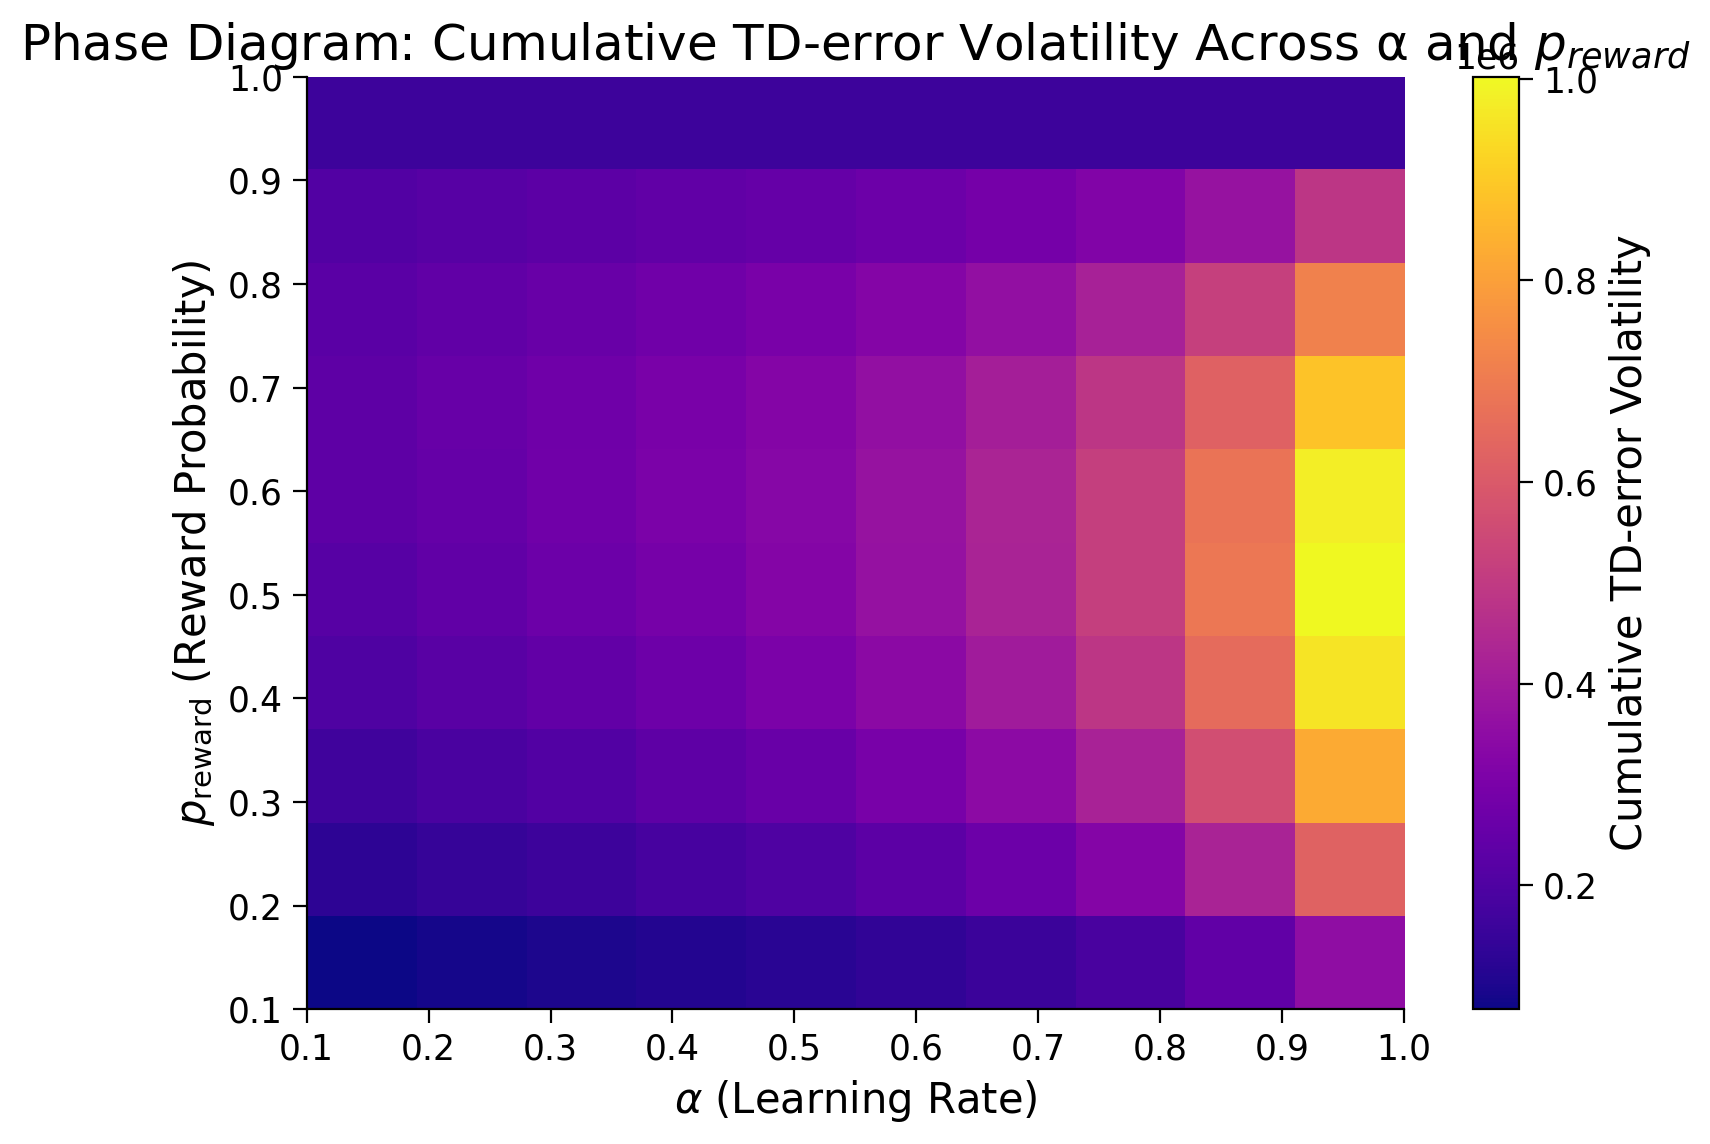

In [71]:
def td_volatility(TDE):
    return np.sum(np.abs(TDE))

n_steps       = 40
reward_mag    = 10
reward_time   = 10
gamma         = 0.98
n_trials      = 20000
cs_time       = int(n_steps/4) - 1
alphas    = np.linspace(0.1, 1.0, 10)  # 10 valores entre 0.1 y 1.0
p_rewards = np.linspace(0.1, 1, 10)   # 0.1, 0.2, …, 0.9

# Matrix for volatility
vol_matrix = np.zeros((len(p_rewards), len(alphas)))
rng_state = np.random.get_state()

for i, p in enumerate(p_rewards):
    for j, alpha in enumerate(alphas):
        np.random.set_state(rng_state)
        # Environment
        env = ProbabilisticCC(
            n_steps=n_steps,
            reward_magnitude=reward_mag,
            reward_time=reward_time,
            p_reward=p
        )
        # TD-learning
        V_est, TDE = td_learner(env, n_trials, alpha=alpha)
        # Macro-measure: Volatility
        vol_matrix[i, j] = td_volatility(TDE)

# heatmap
plt.figure(figsize=(8, 6))
im = plt.imshow(
    vol_matrix,
    origin='lower',
    aspect='auto',
    extent=[alphas[0], alphas[-1], p_rewards[0], p_rewards[-1]], cmap='plasma'
)

plt.colorbar(im, label='Cumulative TD-error Volatility')
plt.xlabel(r'$\alpha$ (Learning Rate)')
plt.ylabel(r'$p_{\mathrm{reward}}$ (Reward Probability)')
plt.title('Phase Diagram: Cumulative TD-error Volatility Across α and $p_{reward}$')
plt.tight_layout()
plt.show()


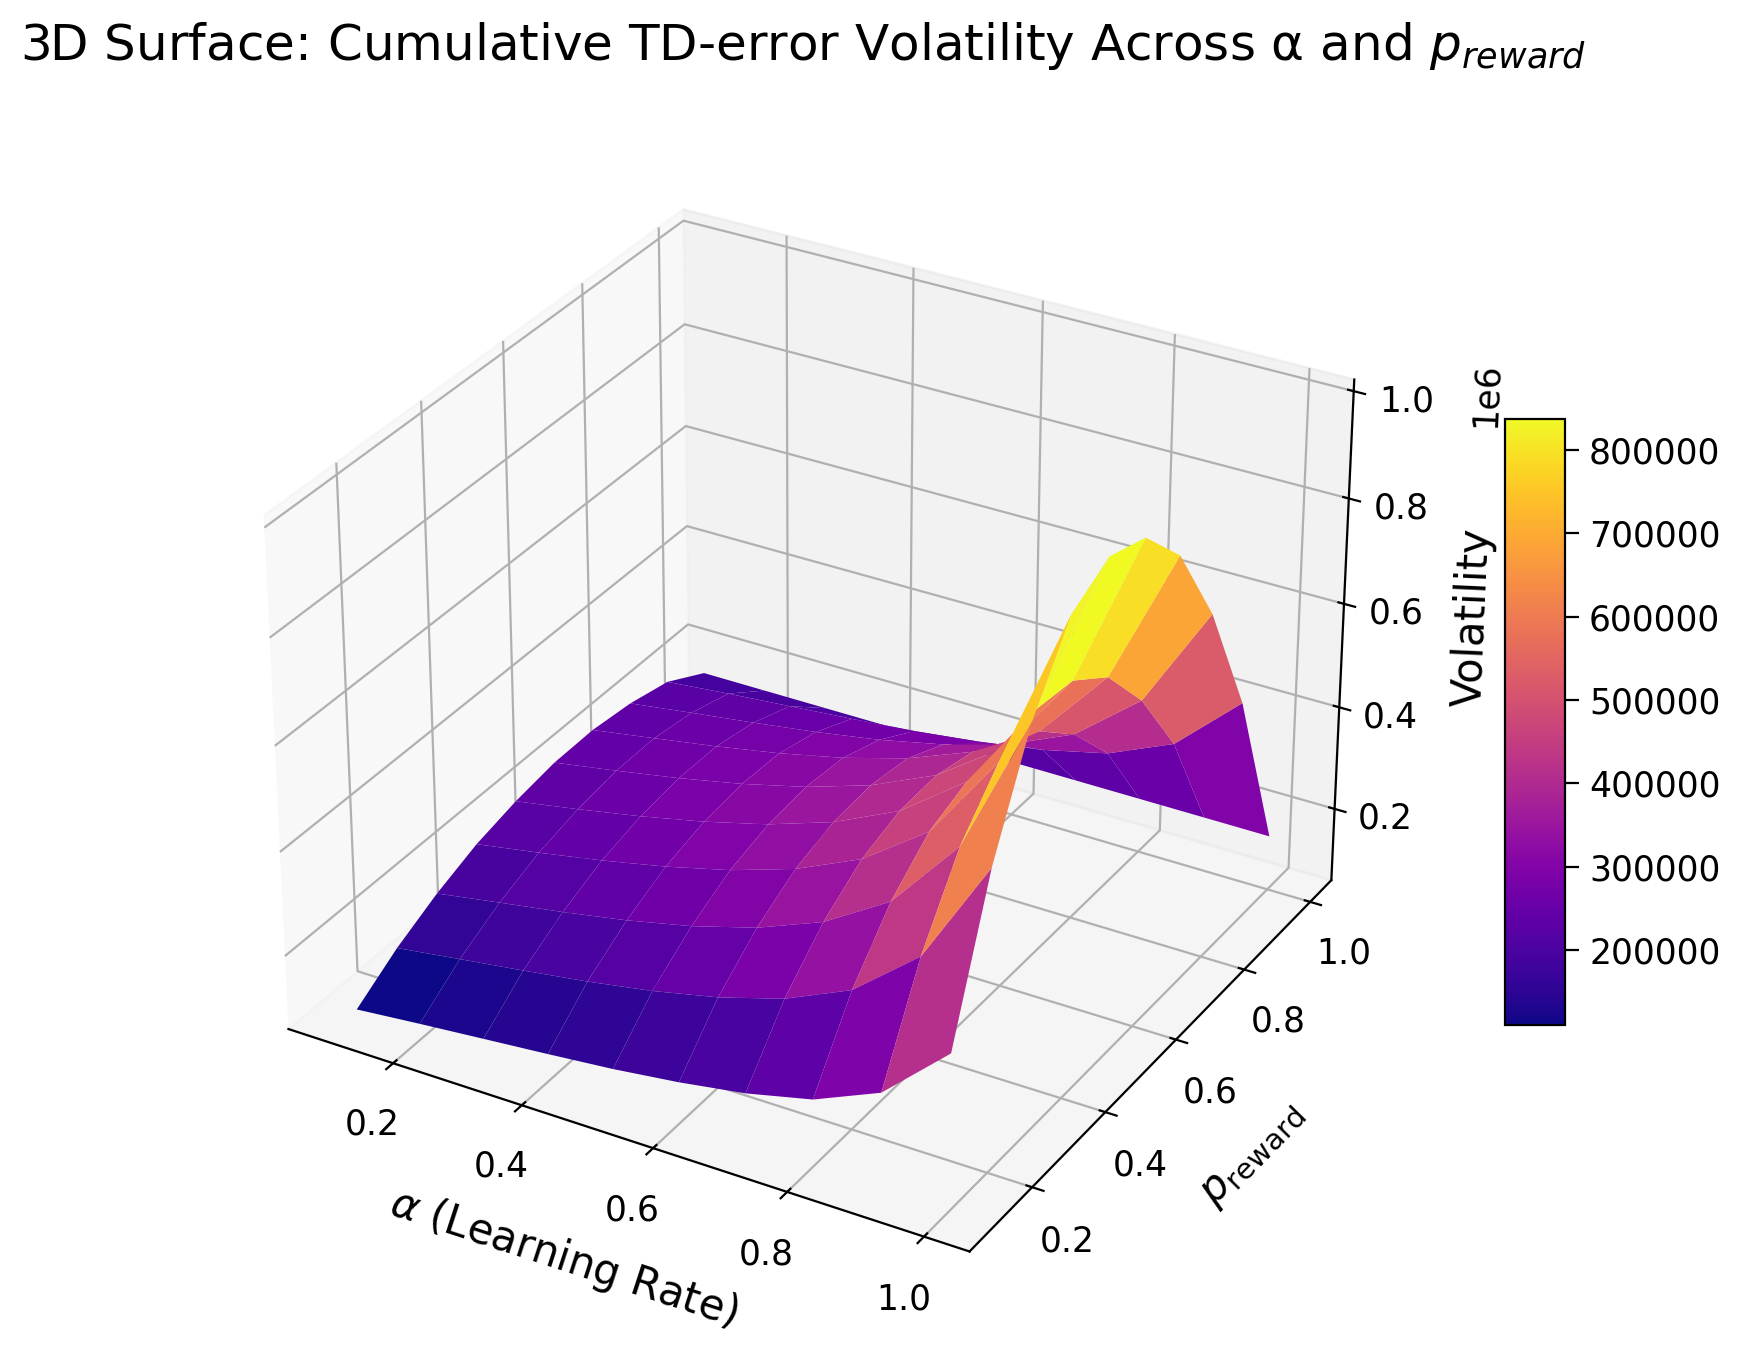

In [72]:
A, P = np.meshgrid(alphas, p_rewards)

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(A, P, vol_matrix, cmap='plasma', edgecolor='none')

# Axis labels
ax.set_xlabel(r'$\alpha$ (Learning Rate)', labelpad=10)
ax.set_ylabel(r'$p_{\mathrm{reward}}$', labelpad=10)
ax.set_zlabel('Volatility', labelpad=8)
ax.set_title('3D Surface: Cumulative TD-error Volatility Across α and $p_{reward}$', pad=20)

# Color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()



## Conclusions. 
 - **Equivalence of stochastic and deterministic reward structures.**  
     Environments with probabilistic rewards (e.g., 10 units with p=0.5) are functionally equivalent to deterministic mixtures (e.g., 50% of 10 units, 50% of 0), as TD-learning responds primarily to the *expected reward* E[R].
  
 - **Volatility reveals dynamic instability.**  
     The cumulative TD-error volatility captures the total reactivity of the agent. 
     - It peaks when α is high and p is near 0.5, i.e., when the environment is noisy and the agent incorporates all updates fully. 
     - Volatility is minimal when the environment is deterministic (p ≈ 0 or p ≈ 1), regardless of α, due to convergence after sufficient episodes.
 
 - **Societal metaphor of (α, p) agents.**  
     A population of agents with heterogeneous (α, p) parameters can be interpreted as a metaphor for human society, where each individual differs in plasticity (learning rate) and exposure to rewarding experiences.
 
 - **Toward an α(p) relationship.**  
     In reality, maybe there is a mathematical non linear relation between $\alpha$ and $p$.